In [878]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from pprint import pprint
from scipy.optimize import minimize
from pynfft.nfft import NFFT
from ExoRIM.definitions import mas2rad, rad2mas
from ExoRIM.operators import NDFTM, Baselines
%matplotlib inline

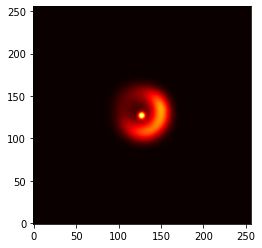

In [698]:
uv_data = fits.open("2004-data1.oifits")
# uv_data = fits.open("blackhole-01-05.oifits")
true_image = fits.open("2004true.fits")[0].data
# true_image = fits.open("blackhole-01-05.fits")[0].data
pixels = true_image.shape[0]
plt.imshow(true_image, cmap="hot", origin="lower")

In [699]:
uv_data["OI_T3"].data["STA_INDEX"].min(axis=0)

array([0, 1, 2], dtype=int16)

Convention for bispectrum:
$$
    B(f_1, f_2) = V(f_1)V(f_2)V(f_1 + f_2) 
$$

In [728]:
try:
    amp_ref = uv_data["OI_VIS"].data["VISAMP"]
    amp_ref_error = uv_data["OI_VIS"].data["VISAMPERR"]
except KeyError:
    amp_ref = np.sqrt(np.abs(uv_data["OI_VIS2"].data["VIS2DATA"])) # 2004 data
    amp_ref_error = np.sqrt(np.sqrt(0.5)/amp * uv_data["OI_VIS2"].data["VIS2ERR"]**2)
    
uv = np.column_stack([uv_data["OI_VIS2"].data["UCOORD"], uv_data[4].data["VCOORD"]])
cp_ref = uv_data["OI_T3"].data["T3PHI"]
cp_ref_error = uv_data["OI_T3"].data["T3PHIERR"]
rho = np.hypot(uv[:, 0], uv[:, 1])
wavel = uv_data["OI_WAVELENGTH"].data["EFF_WAVE"][0] # meter
plate_scale = rad2mas(wavel/15/np.max(rho))
baselines = len(uv_data["OI_VIS2"].data)
apertures = len(uv_data["OI_ARRAY"].data)
triangles = len(uv_data["OI_T3"].data)

print(baselines)
print(triangles)

195
130


Text(0.5, 1.0, 'uv coverage')

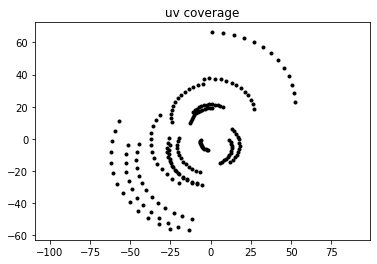

In [729]:
plt.plot(uv[:, 0], uv[:, 1], "k.")
plt.axis("equal")
plt.title("uv coverage")

In [763]:
def uniform_prior(image):
    I = image.sum()
    return np.ones_like(image) / I

In [764]:
def chi2_amp(amp, amp_ref, amp_ref_error):
    return np.mean((amp - amp_ref)**2/amp_ref_error**2)

In [765]:
def chi2_cp(cp, cp_ref, cp_ref_error):
    return np.mean((cp - cp_ref)**2/cp_ref_error**2)

In [766]:
def tikhonov_reg(image, prior=None):
    if prior is None: # uniform prior
        prior = 1./image.sum()
    return np.sum(image**2 / prior)

In [794]:
def safe_log(x):
    out = np.zeros_like(x)
    out[x <= 0] = -1000
    out[x > 0] = np.log(x[x > 0] + 1e-16)
    return out

def maximum_entropy_reg(image, prior=None):
    if prior is None:
        prior = 1./image.sum()
    return np.sum(image * safe_log(image / prior) - image + prior)
    

In [ ]:
def gaussian_prior(uv_data):
    def log_likelihood(params, )

In [795]:
def baseline_projector(uv_data):
    baselines = len(uv_data["OI_VIS2"].data)
    apertures = len(uv_data["OI_ARRAY"].data)
    bp = np.zeros((baselines, apertures))
    indexes = uv_data["OI_VIS2"].data["STA_INDEX"]
    if indexes.min() >= 1:
        indexes -= indexes.min()
    for i in range(baselines):
        bp[i, indexes[i]] = 1
    return bp

def bispectra_projectors(uv_data):
    bp = baseline_projector(uv_data)
    triangles = len(uv_data["OI_T3"].data)
    time_uv = uv_data["OI_VIS2"].data["TIME"]
    time_bispectra = uv_data["OI_T3"].data["TIME"]
    sta_indexes = uv_data["OI_T3"].data["STA_INDEX"]
    if sta_indexes.min() >= 1:
        sta_indexes -= sta_indexes.min()
    
    bisp1 = np.zeros((triangles, bp.shape[0])) # projector to a triangle leg
    bisp2 = np.zeros_like(bisp1)
    bisp3 = np.zeros_like(bisp1)
    bisps = [bisp1, bisp2, bisp3]
    
    legs = [(0, 1), (0, 2), (1, 2)]
    
    # find a mapping between bispectra and each legs of each triangle
    for i, t in enumerate(time_bispectra):
        for j, leg in enumerate(legs):
            baseline = np.where((bp[:, sta_indexes[i, leg]] != 0).all(axis=1) & (time_uv == time_bispectra[i]))[0]
            if len(baseline) == 1:
                bisps[j][i, baseline] = 1
            elif len(baseline) == 0: # this will happen when conjugate baselines are removed
                print(f"No match for V {i}, leg {leg} at time {t}")
            else:
                print(baseline)
    return bisps

        

In [914]:
class ForwardModel:

    def __init__(self, pixels, uv, plate_scale, wavel):
        self.pad = pixels//2
        self.plan = NFFT([2 * pixels, 2 * pixels], uv.shape[0], n=[2 * pixels, 2 * pixels])
        self.phase = np.exp(-1j * np.pi / wavel * mas2rad(plate_scale) * (uv[:, 0] + uv[:, 1]))
        self.bisps = bispectra_projectors(uv_data)
        self.plan.x = uv / wavel * mas2rad(plate_scale)
        self.plan.precompute()

    def visibility(self, image):
        # complex visibility
        image = image.reshape([pixels, pixels])
        _image = np.pad(image.copy(), [[pixels//2, pixels//2], [pixels//2, pixels//2]], mode="constant", constant_values=[(0, 0), (0, 0)])
        self.plan.f_hat = _image.ravel()
        self.plan.trafo()
        vis = self.plan.f.copy() * self.phase
        return vis

    def bispectra(self, V): # lexicographic convention
        V1 = self.bisps[0] @ V
        V2 = self.bisps[1] @ V
        V3 = self.bisps[2] @ V
        return V1 * V2.conj() * V3

    def forward(self, image):
        V = self.visibility(image)
        amp = np.abs(V)
        cp = np.angle(self.bispectra(V))
        return amp, cp
    

<ErrorbarContainer object of 3 artists>

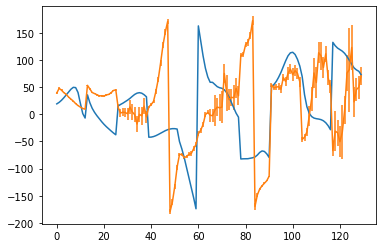

In [915]:
# Check that forward model works as intended

forward = ForwardModel(pixels, uv, plate_scale, wavel)

# f_hat = DFTM(uv)

amp, cp = forward.forward(true_image)
# compare = np.column_stack([np.rad2deg(cp), cp_ref])
# compare2 = np.column_stack([amp, vis_amp_ref])
# compare
plt.plot(np.rad2deg(cp))
plt.errorbar(np.arange(cp_ref.shape[0]), cp_ref, yerr=cp_ref_error)
# plt.plot(amp)
# plt.errorbar(np.arange(amp_ref.shape[0]), amp_ref, yerr=amp_ref_error)

In [913]:
def likelihood(image, amp_ref, amp_ref_error, cp_ref, cp_ref_error, alpha, prior, forward):
    amp, cp = forward.forward(image)
    chi1 = chi2_amp(amp, amp_ref, amp_ref_error)
    chi2 = chi2_cp(cp, cp_ref, cp_ref_error)
#     reg1 = tikhonov_reg(image)
    reg2 = maximum_entropy_reg(image, prior)

    return (chi1 + chi2 + alpha * (reg2)) / (pixels**2 - len(amp_ref) - len(cp_ref))

def grad_likelihood(image, amp_ref, amp_ref_error, cp_ref, cp_ref_error, alpha, prior, forward):
    grad1 = grad_chi1_nfft(image, amp_ref, amp_ref_error, forward)
    grad2 = grad_chi2_nfft(image, cp_ref, cp_ref_error, forward)
    gradr2 = grad_reg2(image, prior)
    return (grad1.ravel() + grad2.ravel() + alpha * gradr2) / (pixels**2 - len(amp_ref) - len(cp_ref))

def grad_chi1_nfft(image, amp_ref, amp_ref_error, forward):
    samples = np.abs(forward.visibility(image))**2
    sigma = amp_ref_error
    amp = amp_ref
    wdiff = -1./vis2_ref.shape[0] * (samples - amp) * samples / sigma**2 / samples * forward.phase.conj()
    
    # inverse fourier transform
    forward.plan.f = wdiff
    out = np.real(forward.plan.adjoint())
    # remove the padding
    out = out.reshape([2*pixels, 2*pixels])
#     plt.imshow(out)
    return out


def grad_chi2_nfft(image, cp_ref, cp_ref_error, forward):
    V = forward.visibility(image)
    V1 = forward.bisps[0] @ V
    V2 = forward.bisps[1] @ V
    V3 = forward.bisps[2] @ V
    cp_samples = np.angle(V1 * V2.conj() * V3)
    
    # gradient for adjoint FFT
    wdiff = 2./len(cp_samples) * np.sin(cp_ref - cp_samples)/cp_ref_error**2
    p1 = wdiff / V1.conj()
    p2 = wdiff / V2
    p3 = wdiff / V3.conj()
    
    plan = NFFT([pixels, pixels], V1.shape[0], n=[pixels, pixels])
    x = forward.plan.x.copy()
    phase = forward.phase.copy()
    
    plan.x = np.einsum("ij, j... -> i...", forward.bisps[0], x)
#     _phase = forward.bisps[0] @ phase
    plan.precompute()
    plan.f = p1
    p1_hat = plan.adjoint() 
    out1 = np.imag(p1_hat)
    
    plan.x = np.einsum("ij, j... -> i...", forward.bisps[1], x)
#     _phase = forward.bisps[1] @ phase
    plan.precompute()
    plan.f = p2.conj()
    p2_hat = plan.adjoint()
    out2 = np.imag(p2_hat)
    
    plan.x = np.einsum("ij, j... -> i...", forward.bisps[2], x)
#     _phase = forward.bisps[2] @ phase
    plan.precompute()
    plan.f = p3
    p3_hat = plan.adjoint()
    out3 = np.imag(p3_hat)
    out = out1 + out2 + out3
#     plt.imshow(out)
    return out

def grad_reg2(image, prior=None):
    if prior is None:
        prior = 1./image.sum()
    out = safe_log(image / prior) + image / prior - 1
    return out

alpha = 1e-1
x = np.arange(pixels) - pixels//2 + 0.5
xx, yy = np.meshgrid(x, x)
rho = np.hypot(xx, yy)
sigma = 10
x0 = 1/2/np.pi/sigma * np.exp(-0.5 * rho**2 / sigma**2)


history = minimize(likelihood, x0, args=(amp_ref, amp_ref_error, cp_ref, cp_ref_error, alpha, x0.ravel(), forward), 
                   method="L-BFGS-B", jac=grad_likelihood, options={"maxiter": 200})



ValueError: operands could not be broadcast together with shapes (262144,) (65536,) 

In [880]:
history

      fun: 373604.1547216218
 hess_inv: <65536x65536 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.09527475e-04,  2.60529892e+06,  5.24861723e+05, ...,
       -6.93914963e+03,  1.09243935e+04, -8.13351900e+04])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 21
      nit: 0
     njev: 21
   status: 2
  success: False
        x: array([3.99782167e-73, 1.42356535e-72, 5.01866788e-72, ...,
       5.01866788e-72, 1.42356535e-72, 3.99782167e-73])

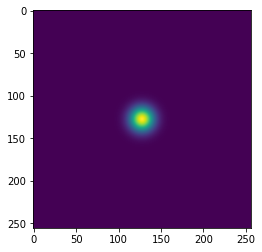

In [881]:
plt.imshow(history.x.reshape([pixels, pixels]))

In [830]:
history

      fun: 1.1833345005022883e+17
 hess_inv: <65536x65536 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.61183869e-01, -1.20731556e-02, -2.59699234e-03, ...,
       -4.27889503e-06, -1.74673460e-04,  4.65964973e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 3
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([9.95137843e-06, 1.39012813e-05, 3.27730119e-06, ...,
       1.24763366e-05, 1.40322198e-06, 6.43060201e-06])

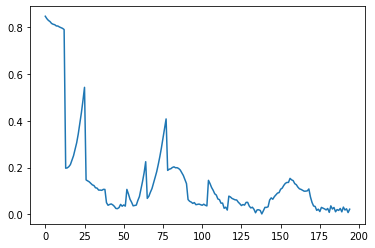

In [834]:
plt.plot(amp_ref)

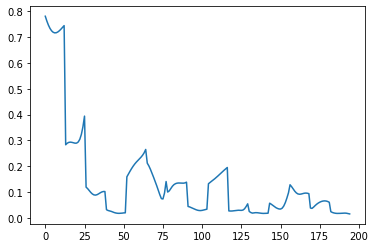

In [836]:
amp = np.abs(forward.visibility(true_image))
plt.plot(amp)

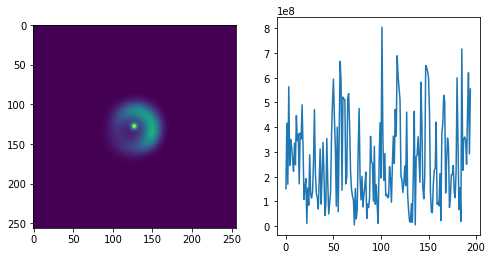

In [889]:
f_hat = true_image + np.random.normal(0, 0.00001, size=true_image.shape)
forward.plan.f_hat = f_hat
forward.plan.trafo()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(true_image + np.random.normal(0, 0.0000000000001, size=true_image.shape))
vis = forward.plan.f.copy() #* self.phase
amp = np.abs(vis)
ax2.plot(amp)

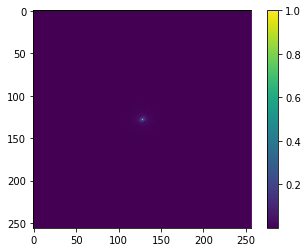

In [846]:
a2 = np.fft.fftshift(np.fft.fft2(x0))
plt.imshow(np.abs(a2))
plt.colorbar()

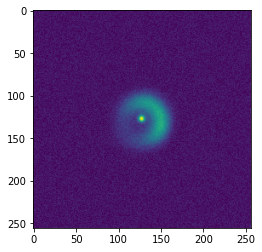

In [847]:
inv = np.fft.ifft2(np.fft.fftshift(a2))
plt.imshow(np.abs(inv))

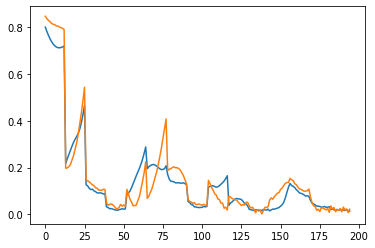

In [894]:
class Baselines:
    UVC = uv
    
A = NDFTM(uv, wavel, pixels, plate_scale)
f = A @ f_hat.ravel()
plt.plot(np.abs(f))
plt.plot(amp_ref)